# Testing Unsupervised + Supervised for Electricity Data

In [62]:
# Import necessary libraries
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime

import mysql.connector
from sqlalchemy import create_engine, Column, Integer, Float, String, DateTime
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, declarative_base

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, make_scorer, accuracy_score, precision_score, f1_score
from sklearn.utils import resample
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import OneClassSVM
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

## Datasets

In [63]:
# Configure database connection
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': '',
    'database': 'db_esp32'
}

# Create engine and session
engine = create_engine('mysql+mysqlconnector://root:@localhost/db_esp32')
Session = sessionmaker(bind=engine)
session = Session()

# Create the Base class
Base = declarative_base()

# Define the ElectricityMonitor class
class ElectricityMonitor(Base):
    __tablename__ = 'electricity_monitor'  # Use your actual table name here
    data_id = Column(Integer, primary_key=True)
    device_id = Column(String(255))
    voltage = Column(Float)
    current = Column(Float)
    power = Column(Float)
    energy = Column(Float)
    frequency = Column(Float)
    power_factor = Column(Float)
    created_at = Column(DateTime)

In [64]:
# Fetch data from the database with only power > 0 and order by created_at in descending order
def fetch_data():
    query = session.query(ElectricityMonitor).where(ElectricityMonitor.power > 0.5).order_by(ElectricityMonitor.created_at.desc())
    df = pd.read_sql(query.statement, query.session.bind)
    return df

# Resample the data to 10% of the original dataset
def sampled_data():
    df_data = fetch_data()
    df_sampled = resample(df_data, replace=False, n_samples=int(len(df_data) * 0.2), random_state=42)

    return df_sampled

## Pre-processing

### Load Datasets

In [65]:
df = fetch_data()
df_sampled = sampled_data()

print(df.head())
print(df.count())

   data_id          device_id  voltage  current  power  energy  frequency  \
0   140364  D4:8A:FC:60:47:60    199.2    0.035    4.1   0.938       49.9   
1   140363  D4:8A:FC:60:47:60    200.1    0.095   11.4   0.938       50.0   
2   140362  D4:8A:FC:60:47:60    198.4    0.094   11.2   0.938       50.0   
3   140361  D4:8A:FC:60:47:60    197.3    0.095   11.2   0.938       50.0   
4   140360  D4:8A:FC:60:47:60    197.4    0.094   11.2   0.938       50.0   

   power_factor          created_at  
0          0.59 2024-07-13 18:05:24  
1          0.60 2024-07-13 18:05:19  
2          0.60 2024-07-13 18:05:14  
3          0.60 2024-07-13 18:05:09  
4          0.60 2024-07-13 18:05:04  
data_id         17782
device_id       17782
voltage         17782
current         17782
power           17782
energy          17782
frequency       17782
power_factor    17782
created_at      17782
dtype: int64


In [66]:
df['power'] = df['power'].round(2)
print(df['power'].describe())
print(df.head())

count    1.778200e+04
mean     1.176624e+04
std      1.566714e+06
min      6.000000e-01
25%      1.080000e+01
50%      1.670000e+01
75%      2.010000e+01
max      2.089200e+08
Name: power, dtype: float64
   data_id          device_id  voltage  current  power  energy  frequency  \
0   140364  D4:8A:FC:60:47:60    199.2    0.035    4.1   0.938       49.9   
1   140363  D4:8A:FC:60:47:60    200.1    0.095   11.4   0.938       50.0   
2   140362  D4:8A:FC:60:47:60    198.4    0.094   11.2   0.938       50.0   
3   140361  D4:8A:FC:60:47:60    197.3    0.095   11.2   0.938       50.0   
4   140360  D4:8A:FC:60:47:60    197.4    0.094   11.2   0.938       50.0   

   power_factor          created_at  
0          0.59 2024-07-13 18:05:24  
1          0.60 2024-07-13 18:05:19  
2          0.60 2024-07-13 18:05:14  
3          0.60 2024-07-13 18:05:09  
4          0.60 2024-07-13 18:05:04  


#### Convert datetime into numeric

In [67]:
# df['created_at'] = df['created_at'].astype('int64') // 10**9



#### Handling missing values

In [68]:
# print(df.isnull().sum())
# df.fillna(df.median(), inplace=True)

#### Calculate new features

In [69]:
# Calculate features
def calculate_features(df):
    df['mean_consumption'] = df['energy'].mean()
    df['std_deviation'] = df['energy'].std()
    df['peak_consumption'] = df['energy'].max()
    return df[['mean_consumption', 'std_deviation', 'peak_consumption', 'created_at']].iloc[-1]


In [70]:
# new_features = calculate_features(df)

## Unsupervised


In [71]:
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)

#### IF

In [72]:
features = ['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']
# Train model
if_model = IsolationForest(contamination=0.1, random_state=42)
if_model.fit(df[features])

# Predict Label
df['if_labels'] = if_model.predict(df[features])

print(df.value_counts('if_labels'))
        

if_labels
 1    16003
-1     1779
Name: count, dtype: int64


#### OCSVM

In [73]:
ocsvm = OneClassSVM(nu=0.1, gamma='auto')

df['ocsvm_labels'] = ocsvm.fit_predict(df[features])  


#### DBSCAN

DBSCAN Labels Distribution:
   data_id          device_id  voltage  current  power  energy  frequency  \
0   140364  D4:8A:FC:60:47:60    199.2    0.035    4.1   0.938       49.9   
1   140363  D4:8A:FC:60:47:60    200.1    0.095   11.4   0.938       50.0   
2   140362  D4:8A:FC:60:47:60    198.4    0.094   11.2   0.938       50.0   
3   140361  D4:8A:FC:60:47:60    197.3    0.095   11.2   0.938       50.0   
4   140360  D4:8A:FC:60:47:60    197.4    0.094   11.2   0.938       50.0   

   power_factor          created_at  if_labels  ocsvm_labels  dbscan_labels  
0          0.59 2024-07-13 18:05:24          1            -1             -1  
1          0.60 2024-07-13 18:05:19          1             1             -1  
2          0.60 2024-07-13 18:05:14          1             1             -1  
3          0.60 2024-07-13 18:05:09          1             1             -1  
4          0.60 2024-07-13 18:05:04          1             1             -1  


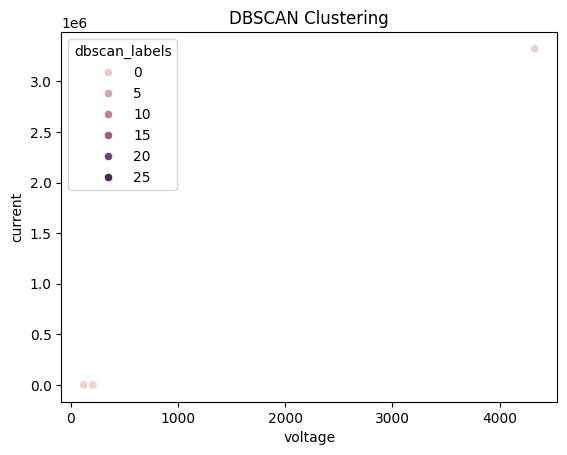

In [74]:
def label_data_with_dbscan(df, eps=0.2, min_samples=25):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df[features])
    df['dbscan_labels'] = clustering.fit_predict(df[features])
    return df

# df_sample = df.sample(n=2000, random_state=42)

label_data_with_dbscan(df)
print("DBSCAN Labels Distribution:")

print(df.head())
# Visualize DBSCAN results
sns.scatterplot(x='voltage', y='current', hue='dbscan_labels', data=df)
plt.title('DBSCAN Clustering')
plt.show()

#### Cluster levels `normal` and `anomaly`

In [75]:
df['if_labels'] = np.where(df['if_labels'] == 1, 'normal', 'anomaly')
df['ocsvm_labels'] = np.where(df['ocsvm_labels'] == 1, 'normal', 'anomaly')
# For DBSCAN, label -1 is considered an anomaly
df['dbscan_labels'] = np.where(df['dbscan_labels'] == -1, 'anomaly', 'normal')

In [76]:
print(df.head())

   data_id          device_id  voltage  current  power  energy  frequency  \
0   140364  D4:8A:FC:60:47:60    199.2    0.035    4.1   0.938       49.9   
1   140363  D4:8A:FC:60:47:60    200.1    0.095   11.4   0.938       50.0   
2   140362  D4:8A:FC:60:47:60    198.4    0.094   11.2   0.938       50.0   
3   140361  D4:8A:FC:60:47:60    197.3    0.095   11.2   0.938       50.0   
4   140360  D4:8A:FC:60:47:60    197.4    0.094   11.2   0.938       50.0   

   power_factor          created_at if_labels ocsvm_labels dbscan_labels  
0          0.59 2024-07-13 18:05:24    normal      anomaly       anomaly  
1          0.60 2024-07-13 18:05:19    normal       normal       anomaly  
2          0.60 2024-07-13 18:05:14    normal       normal       anomaly  
3          0.60 2024-07-13 18:05:09    normal       normal       anomaly  
4          0.60 2024-07-13 18:05:04    normal       normal       anomaly  


In [77]:
filtered_df = df[df['if_labels'] == 'normal']

print(filtered_df.head())

   data_id          device_id  voltage  current  power  energy  frequency  \
0   140364  D4:8A:FC:60:47:60    199.2    0.035    4.1   0.938       49.9   
1   140363  D4:8A:FC:60:47:60    200.1    0.095   11.4   0.938       50.0   
2   140362  D4:8A:FC:60:47:60    198.4    0.094   11.2   0.938       50.0   
3   140361  D4:8A:FC:60:47:60    197.3    0.095   11.2   0.938       50.0   
4   140360  D4:8A:FC:60:47:60    197.4    0.094   11.2   0.938       50.0   

   power_factor          created_at if_labels ocsvm_labels dbscan_labels  
0          0.59 2024-07-13 18:05:24    normal      anomaly       anomaly  
1          0.60 2024-07-13 18:05:19    normal       normal       anomaly  
2          0.60 2024-07-13 18:05:14    normal       normal       anomaly  
3          0.60 2024-07-13 18:05:09    normal       normal       anomaly  
4          0.60 2024-07-13 18:05:04    normal       normal       anomaly  


## Supervised

### RF to IF

voltage: 0.05847792968704724
current: 0.3156692342428966
power: 0.2354988882547088
energy: 0.05053906204683759
frequency: 0.061606886245071095
power_factor: 0.27820799952343883


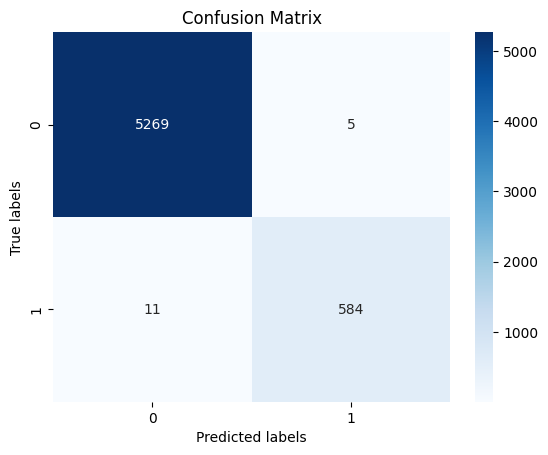

In [81]:
# 'anomaly' is 1 and 'normal' is 0
df['target'] = df['if_labels'].apply(lambda x: 1 if x == 'anomaly' else 0)

# Selecting features for the model (excluding IDs and labels)
X = df[['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']]
y = df['target']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Training a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Getting feature importances
feature_importances = clf.feature_importances_

# Printing feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")
    
# Make predictions on the test set
y_pred = clf.predict(X_test)
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix (Optional)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### RF to DBSCAN

voltage: 0.42877882382862953
current: 0.1275104916495892
power: 0.16391266981510486
energy: 0.21182394693809162
frequency: 0.014819073041441524
power_factor: 0.053154994727143405
dbscan_labels
anomaly    16119
normal      1663
Name: count, dtype: int64
0        anomaly
1        anomaly
2        anomaly
3        anomaly
4        anomaly
          ...   
17777    anomaly
17778    anomaly
17779    anomaly
17780    anomaly
17781    anomaly
Name: dbscan_labels, Length: 17782, dtype: object


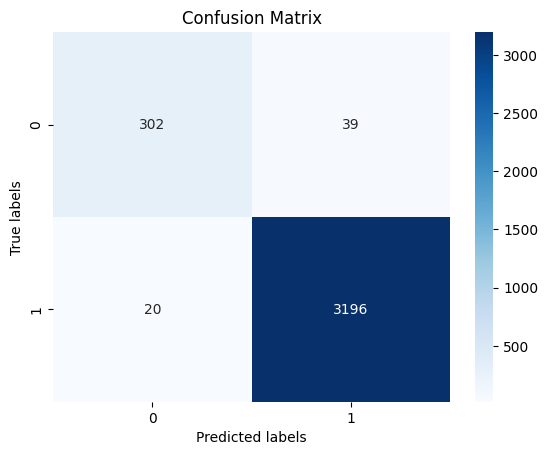

In [79]:
# 'anomaly' is 1 and 'normal' is 0
df['target'] = df['dbscan_labels'].apply(lambda x: 1 if x == 'anomaly' else 0)

# Selecting features for the model (excluding IDs and labels)
X = df[['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']]
y = df['target']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Getting feature importances
feature_importances = clf.feature_importances_

# Printing feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")
    
# Make predictions on the test set
y_pred = clf.predict(X_test)
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

#
print(df['dbscan_labels'].value_counts())
print(df['dbscan_labels'])

# Visualize the confusion matrix (Optional)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### RF to OCSVM

voltage: 0.2572702375311823
current: 0.24211599190486427
power: 0.25925268881228525
energy: 0.14122793922763216
frequency: 0.01229090442888928
power_factor: 0.08784223809514681


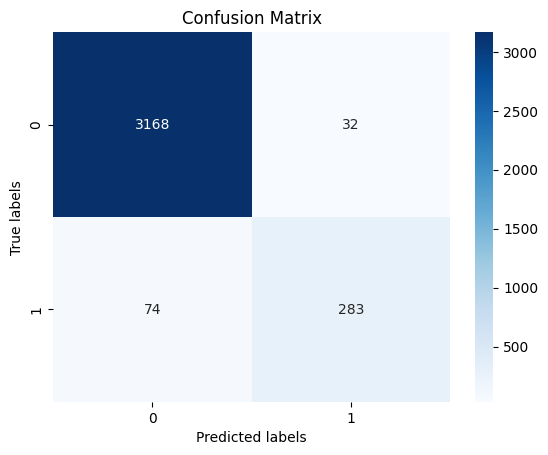

In [80]:
# 'anomaly' is 1 and 'normal' is 0
df['target'] = df['ocsvm_labels'].apply(lambda x: 1 if x == 'anomaly' else 0)

# Selecting features for the model (excluding IDs and labels)
X = df[['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']]
y = df['target']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Getting feature importances
feature_importances = clf.feature_importances_

# Printing feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix (Optional)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### RF confusion Matrix

#### Result